# Word Embedding

In [1]:
from pandas import read_csv, DataFrame, Series
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.downloader import load
from sklearn.metrics.pairwise import cosine_similarity
from networkx import draw_networkx, from_numpy_array, write_graphml

import numpy as np
import re

## Datset Creation

In [7]:
raw_questions: DataFrame = read_csv('./data/Questions.csv', encoding='latin-1')
raw_answers: DataFrame = read_csv('./data/Answers.csv', encoding='latin-1')

In [8]:
raw_answers = raw_answers.sort_values(by='Score', ascending=False)
raw_answers = raw_answers.where(raw_answers['Score'] >= 10).dropna()
answers_txt = raw_answers['Body'].values

raw_questions = raw_questions.sort_values(by='Score', ascending=False)
raw_questions = raw_questions.where(raw_questions['Score'] >= 10).dropna()
questions_txt = raw_questions['Body'].values
questions_title = raw_questions['Title']
questions_title

63011     How to replace master branch in git, entirely,...
208066              What is Redis and what do I use it for?
2822      How do you keep parents of floated elements fr...
739       What are the pros and cons of the SVN plugins ...
294632    offsetting an html anchor to adjust for fixed ...
                                ...                        
401261          How to display raw JSON data on a HTML page
653108       AWS, DigitalOcean vs heroku, google app engine
91797     How can I use iOS's standard red number badges...
218137    Search and replace a particular string in a fi...
267755    Big Headache: CodeIgniter or custom made frame...
Name: Title, Length: 2149, dtype: object

In [ ]:
def clean_body_content(texts):

	def replace_links(match): # remove href link
		if match.group(1):
			return match.group(1)
		else:
			return ' '

	clean_text = []
	for i, text in enumerate(texts):
		text = re.sub(r'\n', ' ', text)
		text = re.sub(r'<a[^>]*>(.*?)</a>', replace_links, text)
		text = re.sub(r'<[^>]+>', ' ', text)
		clean_text.append(text)
	return clean_text

answers_txt = clean_body_content(answers_txt)
questions_txt = clean_body_content(questions_txt)

full_doc_to_clean = []
full_doc_to_clean.extend(answers_txt)
full_doc_to_clean.extend(questions_title)
full_doc_to_clean.extend(questions_txt)

In [22]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(full_doc_to_clean)
tfidf_dict = {}
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    tfidf_dict[ele1] = ele2
tfidf_res = Series(tfidf_dict)
print(tfidf_res.describe())
tfidf_res = tfidf_res.sort_values()
useless_word = tfidf_res.where(tfidf_res >= tfidf_res.mean()).dropna()
useless_word.index

count    208734.000000
mean         11.162529
std           0.978652
min           1.222639
25%          11.182381
50%          11.587846
75%          11.587846
max          11.587846
dtype: float64


Index(['â³', 'âº', 'ã³å', 'dmaxbitmap', '½í²¼', '½í²¾', '½í³', '½wï', '¼ã',
       '¼í¾',
       ...
       'øºû', 'ù¾', 'ù¾ø', 'û²',
       '000000000000000000000000000000000000000000001401', 'û³', 'ûµ',
       '00000000000000000000000000000000000000000000006842277657836021',
       '000000000000000000000000000000000000000000000000',
       '000000000000000000'],
      dtype='object', length=166203)

In [36]:
pattern = re.compile(r'^\d+$') # only number
def clean_stop_words(text: str) -> str:
	words = text.split(' ')
	words = [word for word in words if (word.lower() not in ENGLISH_STOP_WORDS 
									    and word.lower() not in useless_word.index
										and not pattern.match(word))]
	return " ".join(words)
full_doc_to_clean = [clean_stop_words(text) for text in full_doc_to_clean]
questions_title = questions_title.apply(clean_stop_words)

## Analyse

In [24]:
class MyCorpus:
	def __iter__(self):
		for line in full_doc_to_clean:
			yield simple_preprocess(line)

sentences = MyCorpus()
model = Word2Vec(sentences, workers=8)
model.save("data/word2vec.model")

In [25]:
pretrain_model = load('word2vec-google-news-300') # take long time

In [30]:
print(pretrain_model.most_similar(positive=['java'], topn=5))
print(model.wv.most_similar(positive=['java'], topn=5))

[('coffee', 0.6504806876182556), ('o_joe', 0.6308027505874634), ('chai_latte', 0.5802704095840454), ('joe', 0.5795696973800659), ('espresso', 0.567435085773468)]
[('nio', 0.6329073309898376), ('puzzlers', 0.6236855983734131), ('jvm', 0.6217986941337585), ('jdk', 0.6100043654441833), ('sun', 0.5987586975097656)]


In [31]:
model.wv['java']

array([-0.05754837, -0.03482932, -0.6157203 ,  0.44033188, -0.90897506,
        0.14865886, -2.1957767 , -1.2674518 ,  2.920494  ,  2.9055672 ,
       -2.0773442 ,  1.9625409 ,  1.3836683 , -2.3380823 ,  0.9387145 ,
       -1.9205797 ,  0.11060335,  0.65972626, -0.44084322, -0.43664274,
        0.37999532,  0.67856973,  2.060456  , -0.6775537 , -2.6099684 ,
       -1.0470455 ,  1.4184297 , -2.5606298 ,  0.54094   , -1.6764196 ,
        0.7971684 , -0.7515658 ,  2.9702973 ,  1.949478  ,  1.2319369 ,
       -0.2945512 , -2.3856318 ,  0.19922608,  0.58213645,  1.2987533 ,
       -0.2536818 , -2.27641   ,  0.8781962 , -1.9343054 ,  2.281985  ,
       -0.4177481 ,  1.2983687 , -1.569054  ,  1.4150212 , -2.553968  ,
        4.0782676 ,  0.29260477, -2.2681267 ,  1.7588001 , -1.5994593 ,
        0.71146625, -0.85524035, -1.0377762 , -1.0713655 , -1.7017789 ,
        1.8022317 , -0.06182367,  0.18557116, -0.71009827,  0.99439776,
       -1.8181075 , -1.3266402 ,  1.5857731 ,  0.21455301, -0.70

Cette comparaison démontre l'importance de ne pas utiliser un modèle pré-entrainé, car le sens de mot ne sera pas saisit de la même façon qu'avec notre dataset

In [32]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(questions_title.values)
tfidf_dict = {}
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    tfidf_dict[ele1] = ele2

In [33]:

class Doc2vec:
	def __init__(self, tfidf_dict, sentences):
		self.word2vec = Word2Vec(sentences, workers=8)
		self.tfidf_dict: dict = tfidf_dict
	
	def encode(self, sentence):
		vec = np.zeros((1, self.word2vec.vector_size))
		for word in sentence.split(" "):
			try:
				if word.lower() in self.tfidf_dict.keys():
					vec += self.tfidf_dict[word.lower()] * self.word2vec.wv[word.lower()]
				else:
					vec += self.word2vec.wv[word.lower()]
			except:
				pass
		return vec
	
	
	def similarity(self, sentence1, sentence2):
		vec1 = self.encode(sentence1)
		vec2 = self.encode(sentence2)
		return cosine_similarity(vec1, vec2).item()
	
	def series_similarity(self, sentences):
		res = dict()
		for i in range(len(sentences)):
			if i%100==0:
				print(i) 
			for j in range(i, len(sentences)):
				if i != j:
					similarity = self.similarity(sentences[i], sentences[j])
					res[(i, j)] = similarity
		return Series(res)
	
	def matrix_similarity(self, sentences):
		res = np.empty(shape=(len(sentences), len(sentences)))
		for i in range(len(sentences)):
			if i%100==0:
				print(i) 
			for j in range(i, len(sentences)):
				if i != j:
					similarity = self.similarity(sentences[i], sentences[j])
					res[i, j] = similarity
					res[j, i] = similarity
				else:
					res[i, j] = 0
		return res

doc_model = Doc2vec(tfidf_dict, sentences)
doc_model.encode(questions_title.values[0])

array([[-21.30786335, -16.45144248,  21.48592806, -72.82912612,
          5.28186909, -24.67731142,   4.20878249, -13.08264688,
         17.87657118,  -5.50914052, -19.36811757,  33.32581711,
         50.73418063,  39.59069669,  27.72435063,  -9.811378  ,
         24.42506826, -66.15848154,  -3.67384688,   7.27401662,
         33.42491812,   2.72159626,  12.44706529,   8.76819736,
        -14.18195391,  -7.1960426 ,  -5.19312704,  32.1747708 ,
          4.0014224 ,  -4.07921197, -12.39325196,  14.03674698,
        -11.67983109,  -7.91599829,  13.35382104,  37.65738878,
        -25.58455241, -44.61705521, -27.38281742, -25.2990458 ,
        -11.88263571,  33.38217   ,  41.52933824, -12.88967063,
          7.05297765,  10.49524754, -32.41370881, -40.2224081 ,
         20.70614958, -26.03749716, -14.47305828,  16.46360314,
        -28.63682064,  -4.76005733,   1.4937935 , -15.08944499,
         -6.90724457,  19.57210433, -22.86075503,  -9.10042244,
         17.48012251, -11.70730788, -11.

In [37]:
print(questions_title.iloc[10], '/', questions_title.iloc[12], doc_model.similarity(questions_title.iloc[10], questions_title.iloc[12]))
print()
print(questions_title.iloc[35], '/', questions_title.iloc[37], doc_model.similarity(questions_title.iloc[35], questions_title.iloc[37]))
print()
print(questions_title.iloc[0], '/', questions_title.iloc[3], doc_model.similarity(questions_title.iloc[0], questions_title.iloc[3]))


non-programming books programmers read? / better Windows Console Window? 0.061019699154000906

common uses Python decorators? / LINQ - Fluent Query Expression - benefit(s) other? 0.17299148342721463

replace master branch git, entirely, branch? / pros cons SVN plugins Eclipse, Subclipse Subversive? 0.3608282249719598


In [38]:
res = doc_model.series_similarity(questions_title.values[:500])
res.describe()

0
100
200
300
400


count    124750.000000
mean          0.178831
std           0.164648
min          -0.399378
25%           0.063680
50%           0.171014
75%           0.283286
max           1.000000
dtype: float64

## Graphe

In [39]:
matrix = doc_model.matrix_similarity(questions_title.values[:500])

0
100
200
300
400


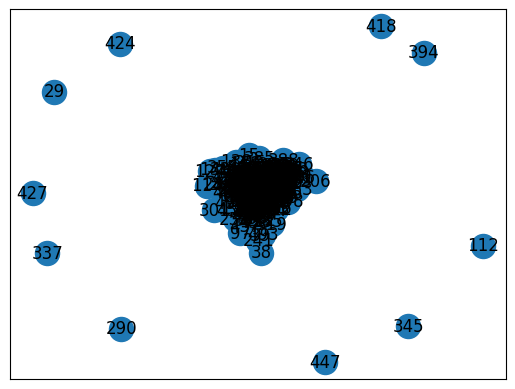

In [43]:
matrix = np.where(matrix > 0.9, 1, 0)
G = from_numpy_array(matrix)
draw_networkx(G)
write_graphml(G, 'data/WordEmbeddingGraph.graphml')

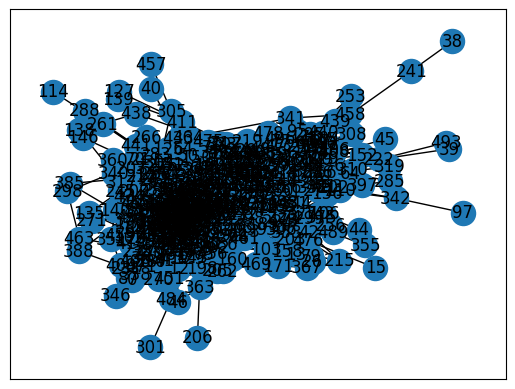

In [45]:
def remove_node(G, min_degree):
	remove_list = []
	for node in G.nodes:
		if G.degree(node) < min_degree:
			remove_list.append(node)
	G_local = G.copy()
	G_local.remove_nodes_from(remove_list)
	return G_local

G_clean1 = remove_node(G, 1)
draw_networkx(G_clean1)